In [10]:
using LinearAlgebra
using DifferentialEquations
using ForwardDiff
using Geodesy
using ForwardDiff
using Optim
using Plots

In [26]:
#GS Locations
wean_lla = LLA(40.4427217, -79.9479335, 17.0)
wean_ecef = ECEF(wean_lla, wgs84)
gs1_ecef = Array(wean_ecef)./(1000.0)
nrec_lla = LLA(40.4712452, -79.9661841, 16.6)
nrec_ecef = ECEF(nrec_lla, wgs84)
gs2_ecef = Array(nrec_ecef)./(1000.0)
gascola_lla = LLA(40.4652298, -79.7889967, 268.0)
gascola_ecef = ECEF(gascola_lla, wgs84)
gs3_ecef = Array(gascola_ecef)./(1000.0)

3-element Array{Float64,1}:
   861.4698551451598
 -4782.578107155552
  4117.597114794921

In [56]:
gs3_ecef-gs1_ecef

3-element Array{Float64,1}:
 13.020303773756723
  3.780056495419558
  2.064743803579404

In [57]:
gs3_ecef-gs2_ecef

3-element Array{Float64,1}:
 14.903093544626358
  2.0259836107279625
 -0.3450163820407397

In [58]:
gs2_ecef-gs1_ecef

3-element Array{Float64,1}:
 -1.8827897708696355
  1.7540728846915954
  2.4097601856201436

In [27]:
function ecef2eci(x_ecef,t)
    Ω = 2*pi/86164.0905 #rad/sec
    θ = Ω*t
    c = cos(Ω*t)
    s = sin(Ω*t)
    
    x_eci = [c -s 0; s c 0; 0 0 1]*x_ecef
end

ecef2eci (generic function with 1 method)

In [48]:
function dynamics!(xdot,x,params,t)
    μ = 398600.44 #km^3/s^2
    r = x[1:3]
    v = x[4:6]
    
    a = -(μ/(norm(r)^3)).*r
    
    xdot .= [v; a]
end

function backward_dynamics!(xdot,x,params,t)
    μ = 398600.44 #km^3/s^2
    r = x[1:3]
    v = x[4:6]
    
    a = -(μ/(norm(r)^3)).*r
    
    xdot .= [-v; -a]
end

function f_c(x)
    μ = 398600.44 #km^3/s^2
    r = x[1:3]
    v = x[4:6]
    
    a = -(μ/(norm(r)^3)).*r
    
    return [v; a]
end

function f_d(x)
    h = 0.1 #RK4 step (seconds)
    
    k1 = f_c(x)
    k2 = f_c(x + 0.5*h*k1)
    k3 = f_c(x + 0.5*h*k2)
    k4 = f_c(x + h*k3)
    
    return x + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
end

function A(x)
    return ForwardDiff.jacobian(f_d, x)
end

A (generic function with 1 method)

In [49]:
function g(x,t)
    gs1_eci = ecef2eci(gs1_ecef,t)
    gs2_eci = ecef2eci(gs2_ecef,t)
    gs3_eci = ecef2eci(gs3_ecef,t)

    r1 = norm(x[1:3]-gs1_eci)
    r2 = norm(x[1:3]-gs2_eci)
    r3 = norm(x[1:3]-gs3_eci)
        
    y = [r2-r1; r3-r1; r3-r2]
    #y = r2-r1
end

function g_diffable(xt)
    return g(xt[1:end-1], xt[end])
end

function C(x,t)
    C1 = ForwardDiff.jacobian(g_diffable, [x; t]) #3 receivers
    return C1[:,1:end-1]
    #C1 = ForwardDiff.gradient(g_diffable, [x; t]) #2 receivers
    #return C1[1:end-1]
end

C (generic function with 1 method)

In [50]:
#Initial Conditions (polar orbit passing directly over GS at t=0)
μ = 398600.44 #km^3/s^2
Re = 6371.0 #km
r0 = (Re+550)*(gs1_ecef/norm(gs1_ecef))
v0 = cross(r0, cross(r0,[0;0;1]))
v0 = sqrt(μ/norm(r0))*v0/norm(v0)
x0 = [r0; v0]

6-element Array{Float64,1}:
   921.9556818709577
 -5201.028272470356
  4472.084930949979
     0.8559101404321281
    -4.82844558216481
    -5.791927837238977

In [51]:
#Integrate backward for 5 minutes
tspan = (0.0,5.0*60.0)
prob1 = ODEProblem(backward_dynamics!,[r0; v0],tspan)
soln1 = solve(prob1, Tsit5(), reltol=1e-9, abstol=1e-9)

#Integrate forward for 5 minutes
tspan = (0.0,5.0*60.0)
prob2 = ODEProblem(dynamics!,[r0; v0],tspan)
soln2 = solve(prob2, Tsit5(), reltol=1e-9, abstol=1e-9)

#Sample satellite state every 0.1 seconds
thist = Array(range(-5.0*60.0, 5.0*60.0, step=0.1))
xhist = zeros(6,length(thist))
for k = 1:length(thist)
    if thist[k] < 0.0
        xhist[:,k] .= soln1(-thist[k])
    else
        xhist[:,k] .= soln2(thist[k])
    end
end

In [52]:
#Calculate elevation
ele = zeros(length(thist))
for k = 1:length(thist)
    gs1_eci = ecef2eci(gs1_ecef,thist[k])
    y = (xhist[1:3,k]-gs1_eci)
    ele[k] = (y/norm(y))'*(gs1_eci/norm(gs1_eci))
end

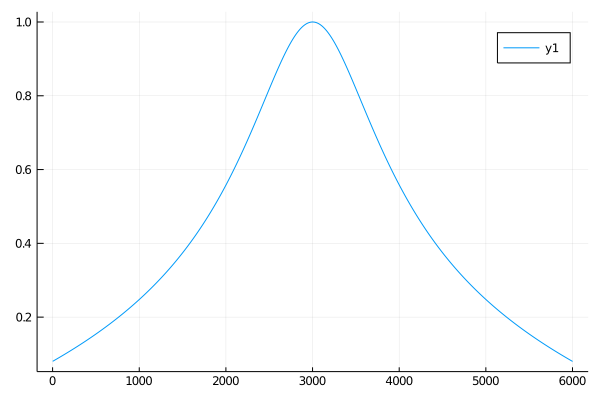

In [53]:
plot(ele)

In [54]:
#Observability Grammian Check
Φ = Array(Diagonal(ones(6)))
J = zeros(3*length(thist),6)
for k = 1:length(thist)
    Φ .= A(xhist[:,k])*Φ
    J[(3*(k-1)).+(1:3),:] .= C(xhist[:,k],thist[k])*Φ #3 receivers
    #J[k-54,:] .= Φ*C(xhist[:,1],thist[1]) #2 recievers
end
Jfact = qr(J)
cond(Jfact.R)

184372.77793385333

In [71]:
#Cramer-Rao Bound
R = Array(Diagonal(0.24*0.24.*ones(3))) #measurement noise covariance
Rinv = inv(R)
#R = 0.24*0.24

C1 = C(xhist[:,1],thist[1])
S = C1'*Rinv*C1 #inverse state covariance (information)
for k = 2:length(thist)
    Ainv = inv(A(xhist[:,k-1]))
    Ck = C(xhist[:,k],thist[k])
    S = Ainv'*S*Ainv + Ck'*Rinv*Ck
end
sqrt(Diagonal(S^-1))

6×6 Diagonal{Float64,Array{Float64,1}}:
 8.22459    ⋅        ⋅       ⋅          ⋅         ⋅ 
  ⋅       70.2678    ⋅       ⋅          ⋅         ⋅ 
  ⋅         ⋅      50.8223   ⋅          ⋅         ⋅ 
  ⋅         ⋅        ⋅      0.0213837   ⋅         ⋅ 
  ⋅         ⋅        ⋅       ⋅         0.192303   ⋅ 
  ⋅         ⋅        ⋅       ⋅          ⋅        0.197309

In [63]:
#Generate noisy Measurements
yhist = zeros(3,length(thist))
for k = 1:length(thist)        
        yhist[:,k] .= g(xhist[:,k], thist[k]) + 0.05*randn(3)
end

In [64]:
function lsobj(x)
    Qinv = Array(Diagonal([1e6*ones(3); 1e8*ones(3)]))
    Rinv = Array(Diagonal((1/(0.24*0.24))*ones(3)))
    cost = 0.0
    xhist = reshape(x,6,:)
    for k = 1:(size(xhist,2)-1)
        ex = (xhist[:,k+1]-f_d(xhist[:,k]))
        cost = cost + ex'*Qinv*ex
    end
    for k = 1:(size(xhist,2))
        ey = (yhist[:,k]-g(xhist[:,k],thist[k]))
        cost = cost + ey'*Rinv*ey
    end
    return cost
end

lsobj (generic function with 1 method)

In [65]:
function gradobj!(g,x)
    ForwardDiff.gradient!(g,lsobj,x)
end

function hessobj!(H,x)
    ForwardDiff.hessian!(H,lsobj,x)
end

hessobj! (generic function with 1 method)

In [74]:
#This is really slow with more than a couple dozen measurements
#result = optimize(lsobj, gradobj!, hessobj!, xhist[:]+.01*randn(length(xhist[:])), Newton())

In [75]:
#error = xhist - reshape(result.minimizer,6,:)